* Main model: This is the main model which produced the best results.
* Ensemble classifier: Doesnot produced promising results and training time was too high.
* Data analysis: Just for the analysis of data results kept in ppt already.

# Main model
**Data link train:** https://drive.google.com/file/d/1CIDHhNi3ikwSznm1op_LLRQ3Z29E_G49/view?usp=sharing

**test:** https://drive.google.com/file/d/1MzUBVC1eDvorp4Mp2Lp28_0QIAlqhm14/view?usp=sharing


**Dataset Description**
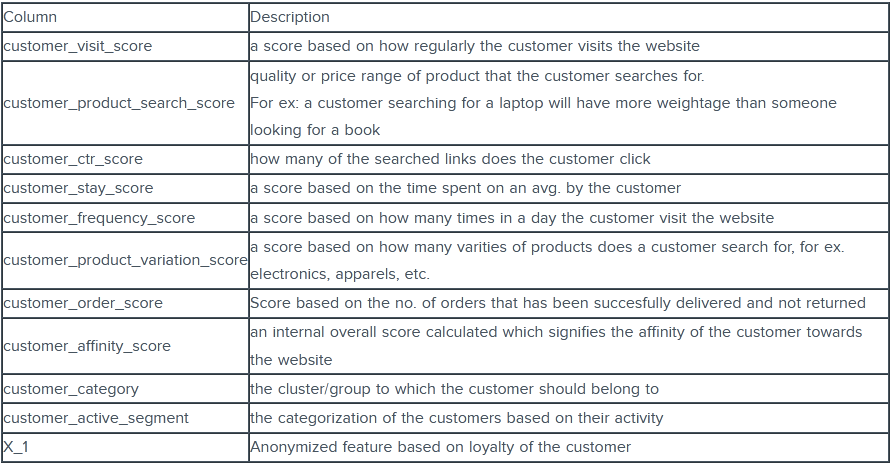

In [ ]:
!mkdir data
!gdown 'https://drive.google.com/uc?id=1CIDHhNi3ikwSznm1op_LLRQ3Z29E_G49'

Downloading...
From: https://drive.google.com/uc?id=1CIDHhNi3ikwSznm1op_LLRQ3Z29E_G49
To: /content/train.csv
100% 1.81M/1.81M [00:00<00:00, 58.2MB/s]


In [ ]:
!mkdir data
!gdown 'https://drive.google.com/uc?id=1MzUBVC1eDvorp4Mp2Lp28_0QIAlqhm14'

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?id=1MzUBVC1eDvorp4Mp2Lp28_0QIAlqhm14
To: /content/test.csv
100% 1.20M/1.20M [00:00<00:00, 76.1MB/s]


In [ ]:
#import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

from collections import Counter
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [ ]:
#reading the training data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
combine = [train_df, test_df]

**Checking for outerlier if any**

In [ ]:
def Turkey(df,n,features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        
        IQR=Q3-Q1
        
        outlier_step = 1.5 *IQR
        outlier_list_col = df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    #observation which contains more than n outliers    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

Outliers_to_drop = Turkey(train_df,2,["customer_visit_score","customer_product_search_score" ,"customer_ctr_score","customer_stay_score","customer_frequency_score","customer_product_variation_score","customer_order_score","customer_affinity_score"])

In [ ]:
train_df.loc[Outliers_to_drop]
#there isnot much outlier except the first "customer_visit_score" where we have some values greater than 42.
#that will not affect much 

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
364,csid_365,42.194958,NaN,-0.331652,0.098879,29.262849,10.397793,1.165420,-0.168622,AA,BA,0
7472,csid_7473,42.342567,8.480601,-0.480228,0.147315,44.461976,14.547097,1.799795,-0.003156,AA,F,0
8936,csid_8937,43.757270,7.723078,-0.383069,0.155433,30.390937,13.005492,0.892201,-0.203162,AA,BA,0
9529,csid_9530,43.926748,8.172522,-0.547989,0.429055,22.085505,14.761771,1.646379,-0.075156,AA,BA,0


In [ ]:
#dropping outliers
print(train_df.shape[0])
train_df=train_df.drop(Outliers_to_drop,axis=0).reset_index(drop=True)
print(train_df.shape[0])
combine = [train_df, test_df]


10738
10734


In [ ]:
#checking null value
train_df.isnull().sum()

customer_id                          0
customer_visit_score                 0
customer_product_search_score       41
customer_ctr_score                   0
customer_stay_score                 37
customer_frequency_score             0
customer_product_variation_score    46
customer_order_score                66
customer_affinity_score              0
customer_active_segment             23
X1                                  37
customer_category                    0
dtype: int64

**Data Description**

In [ ]:
train_df.describe(include=['object'])

,customer_id,customer_active_segment,X1
count,10734,10711,10697
unique,10734,5,5
top,csid_5348,C,BA
freq,1,4919,4508


In [ ]:
train_df.describe(include=['number'])

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_category
count,10734.000000,10693.000000,10734.000000,10697.000000,10734.000000,10688.000000,10668.000000,10734.000000,10734.000000
mean,19.052000,5.274047,0.176140,0.374292,2.366023,5.785414,3.150736,17.068236,0.120645
std,7.406500,1.882210,0.372708,1.222252,5.572370,2.527517,1.035015,18.763259,0.325729
min,0.568965,-0.161940,-0.546227,-0.462494,0.028575,2.752836,0.363338,-0.486834,0.000000
25%,13.517130,3.971447,0.010928,-0.027687,0.313597,4.193017,2.454935,4.538476,0.000000
50%,18.765232,5.218149,0.074218,0.037174,0.516777,4.842166,3.119224,12.665472,0.000000
75%,24.485527,6.518056,0.159678,0.179029,1.123790,6.283021,3.757311,23.120238,0.000000
max,47.306691,16.638243,2.679474,14.701914,52.395014,18.743836,9.090206,248.552755,1.000000


In [ ]:
train_df[['X1','customer_category']].groupby(['X1'], as_index=False).count().sort_values(by='X1')

,X1,customer_category
0,A,2268
1,AA,1611
2,BA,4508
3,E,76
4,F,2234


In [ ]:
train_df.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


**Handling the missing value**

In [ ]:
print('mean before imputation',train_df['customer_product_search_score'].mean())
#we can see that 50% data is 5.218479 	and 75 % data is around 6.520364 	hence doing the imputation using mean.
print('mean after imputation',train_df['customer_product_search_score'].fillna(train_df['customer_product_search_score'].mean()).mean())
print("Before imputation")
print(train_df['customer_product_search_score'].isnull().sum())
temp = train_df['customer_product_search_score'].mean()
print(temp)
for data in combine:
  data['customer_product_search_score'] = data['customer_product_search_score'].fillna(temp)
#train_df['customer_product_search_score'] = train_df['customer_product_search_score'].fillna(temp)
print("After imputation")
print(train_df['customer_product_search_score'].isnull().sum())

mean before imputation 5.274047409213424
mean after imputation 5.274047409213424
Before imputation
41
5.274047409213424
After imputation
0


In [ ]:
print('mean before imputation',train_df['customer_stay_score'].mean())
#we can see that 50% data is 5.218479 	and 75 % data is around 6.520364 	hence doing the imputation using mean.
print('mean after imputation',train_df['customer_stay_score'].fillna(train_df['customer_stay_score'].mean()).mean())
print("Before imputation")
print(train_df['customer_stay_score'].isnull().sum())
temp = train_df['customer_stay_score'].mean()
for data in combine:
  data['customer_stay_score']=data['customer_stay_score'].fillna(temp)
print("After imputation")
print(train_df['customer_stay_score'].isnull().sum())

mean before imputation 0.37429234456814353
mean after imputation 0.37429234456814336
Before imputation
37
After imputation
0


In [ ]:

print('mean before imputation',train_df['customer_product_variation_score'].mean())
#we can see that 50% data is 5.218479 	and 75 % data is around 6.520364 	hence doing the imputation using mean.
print('mean after imputation',train_df['customer_product_variation_score'].fillna(train_df['customer_product_variation_score'].mean()).mean())
print("Before imputation")
print(train_df['customer_product_variation_score'].isnull().sum())
temp = train_df['customer_product_variation_score'].mean()
for data in combine:
  data['customer_product_variation_score']=data['customer_product_variation_score'].fillna(temp)
print("After imputation")
print(train_df['customer_product_variation_score'].isnull().sum()) 



mean before imputation 5.785413863002932
mean after imputation 5.7854138630029395
Before imputation
46
After imputation
0


In [ ]:


print('mean before imputation with mean',train_df['customer_order_score'].mean())
#we can see that 50% data is 5.218479 	and 75 % data is around 6.520364 	hence doing the imputation using mean.
print('mean after imputation',train_df['customer_order_score'].fillna(train_df['customer_order_score'].mean()).mean())
print('mean after imputation with median',train_df['customer_order_score'].fillna(train_df['customer_order_score'].median()).mean())
print("Before imputation")
print(train_df['customer_order_score'].isnull().sum())
temp = train_df['customer_order_score'].mean()
for data in combine:
  data['customer_order_score']=data['customer_order_score'].fillna(temp)
print("After imputation")
print(train_df['customer_order_score'].isnull().sum())


mean before imputation with mean 3.150735751049987
mean after imputation 3.1507357510499836
mean after imputation with median 3.1505419951612366
Before imputation
66
After imputation
0


In [ ]:

print('mean before imputation with mean:',train_df['customer_active_segment'].mode()[0])

print("Before imputation")
print(train_df['customer_active_segment'].isnull().sum())
for data in combine:
  data['customer_active_segment'] = data['customer_active_segment'].fillna(train_df['customer_active_segment'].mode()[0])
print("After imputation")
print(train_df['customer_active_segment'].isnull().sum())

mean before imputation with mean: C
Before imputation
23
After imputation
0


In [ ]:
print('mean before imputation with mean:',train_df['X1'].mode()[0])

print("Before imputation")
print(train_df['X1'].isnull().sum())
for data in combine:
  data['X1'] = data['X1'].fillna(train_df['X1'].mode()[0])
print("After imputation")
print(train_df['X1'].isnull().sum())

mean before imputation with mean: BA
Before imputation
37
After imputation
0


**Label Encoding**

In [ ]:
#label encoding
print(train_df[['customer_active_segment','customer_category']].groupby(['customer_active_segment'], as_index=False).count().sort_values(by='customer_active_segment'))
cas_map={"A":0,"AA":1,"B":2,"C":3,"D":4}
for data in combine:
    data['customer_active_segment']=data['customer_active_segment'].map(cas_map).astype(int)
train_df['customer_active_segment']

  customer_active_segment  customer_category
0                       A                412
1                      AA                414
2                       B               4430
3                       C               4942
4                       D                536


0        3
1        3
2        3
3        1
4        3
        ..
10729    3
10730    3
10731    0
10732    2
10733    2
Name: customer_active_segment, Length: 10734, dtype: int64

In [ ]:
#label encoding
X1_map={"A":0,"AA":1,"BA":2,"E":3,"F":4}
for data in combine:
    data['X1']=data['X1'].map(X1_map).astype(int)
train_df['X1']

0        4
1        0
2        2
3        4
4        1
        ..
10729    2
10730    2
10731    2
10732    1
10733    0
Name: X1, Length: 10734, dtype: int64

In [ ]:
#no missing values
train_df.isnull().sum()

customer_id                         0
customer_visit_score                0
customer_product_search_score       0
customer_ctr_score                  0
customer_stay_score                 0
customer_frequency_score            0
customer_product_variation_score    0
customer_order_score                0
customer_affinity_score             0
customer_active_segment             0
X1                                  0
customer_category                   0
dtype: int64

In [ ]:
train_df.iloc[:,-1].head()

0    0
1    0
2    0
3    0
4    0
Name: customer_category, dtype: int64

Text(0, 0.5, 'Cumulative explained variance')

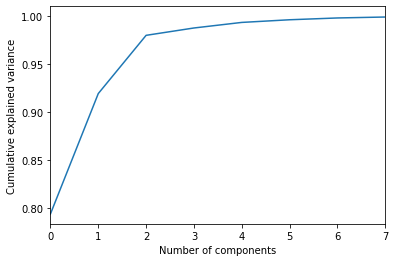

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 11)
pca = pca.fit(train_df.iloc[:,1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


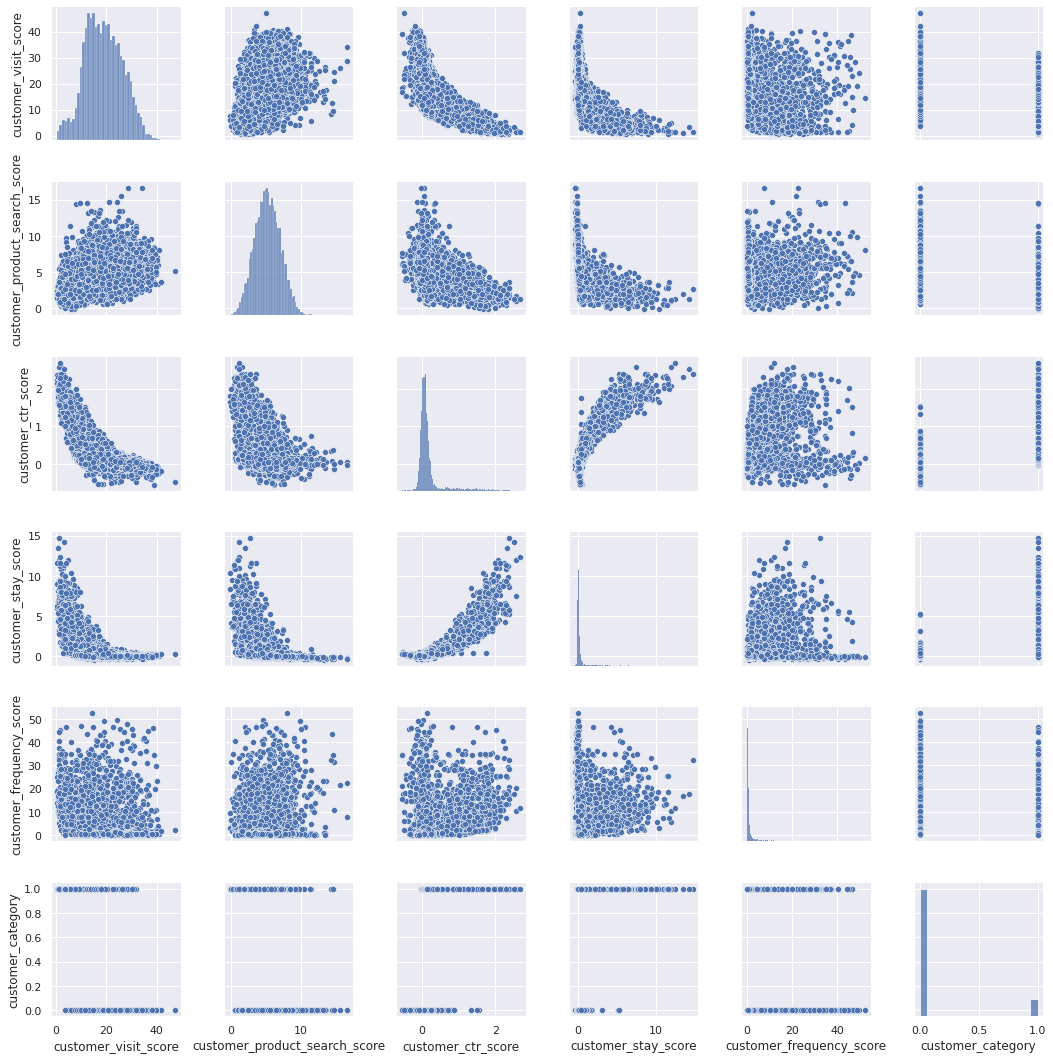

In [27]:
sns.set()
cols = ["customer_visit_score","customer_product_search_score" ,"customer_ctr_score","customer_stay_score","customer_frequency_score","customer_category"]
sns.pairplot(train_df[cols], size = 2.5)
plt.show()

**Data grouping**

In [ ]:
Dataset = train_df.copy()
Dataset['cust_ctr_score_band']=pd.cut(Dataset['customer_ctr_score'],4)
Dataset[['cust_ctr_score_band','customer_category']].groupby(['cust_ctr_score_band'],as_index=False).mean().sort_values(by='cust_ctr_score_band')

,cust_ctr_score_band,customer_category
0,"(-0.549, 0.26]",0.016143
1,"(0.26, 1.067]",0.673696
2,"(1.067, 1.873]",0.993213
3,"(1.873, 2.679]",1.000000


In [ ]:
Dataset['cust_visit_band']=pd.cut(Dataset['customer_visit_score'],6)
Dataset[['cust_visit_band','customer_category']].groupby(['cust_visit_band'],as_index=False).mean().sort_values(by='cust_visit_band')

,cust_visit_band,customer_category
0,"(0.522, 8.359]",0.905344
1,"(8.359, 16.148]",0.138062
2,"(16.148, 23.938]",0.052211
3,"(23.938, 31.727]",0.013256
4,"(31.727, 39.517]",0.002123
5,"(39.517, 47.307]",0.000000


In [28]:
train_df.loc[train_df['customer_visit_score']<=8.359,'customer_visit_score']=0
train_df.loc[(train_df['customer_visit_score']>8.359) & (train_df['customer_visit_score']<=16.148),'customer_visit_score']=1
train_df.loc[(train_df['customer_visit_score']>16.148) & (train_df['customer_visit_score']<=23.938),'customer_visit_score']=2
train_df.loc[(train_df['customer_visit_score']>23.938) & (train_df['customer_visit_score']<=31.727),'customer_visit_score']=3
train_df.loc[(train_df['customer_visit_score']>31.727) & (train_df['customer_visit_score']<=39.517),'customer_visit_score']=4
train_df.loc[(train_df['customer_visit_score']>39.517),'customer_visit_score']


train_df.loc[train_df['customer_ctr_score']<=0.26,'customer_ctr_score']=0
train_df.loc[(train_df['customer_ctr_score']>0.26) & (train_df['customer_ctr_score']<=1.067),'customer_ctr_score']=1
train_df.loc[(train_df['customer_ctr_score']>1.067) & (train_df['customer_ctr_score']<=1.873),'customer_ctr_score']=2
train_df.loc[(train_df['customer_ctr_score']>1.873),'customer_ctr_score']


test_df.loc[test_df['customer_visit_score']<=8.359,'customer_visit_score']=0
test_df.loc[(test_df['customer_visit_score']>8.359) & (test_df['customer_visit_score']<=16.148),'customer_visit_score']=1
test_df.loc[(test_df['customer_visit_score']>16.148) & (test_df['customer_visit_score']<=23.938),'customer_visit_score']=2
test_df.loc[(test_df['customer_visit_score']>23.938) & (test_df['customer_visit_score']<=31.727),'customer_visit_score']=3
test_df.loc[(test_df['customer_visit_score']>31.727) & (test_df['customer_visit_score']<=39.517),'customer_visit_score']=4
test_df.loc[(test_df['customer_visit_score']>39.517),'customer_visit_score']


test_df.loc[test_df['customer_ctr_score']<=0.26,'customer_ctr_score']=0
test_df.loc[(test_df['customer_ctr_score']>0.26) & (test_df['customer_ctr_score']<=1.067),'customer_ctr_score']=1
test_df.loc[(test_df['customer_ctr_score']>1.067) & (test_df['customer_ctr_score']<=1.873),'customer_ctr_score']=2
test_df.loc[(test_df['customer_ctr_score']>1.873),'customer_ctr_score']


train_df

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,1.0,9.447662,0.0,-0.139541,0.436956,4.705761,2.537985,7.959503,3,4,0
1,csid_2,2.0,7.329056,0.0,-0.102726,0.380340,4.205138,4.193444,17.517381,3,0,0
2,csid_3,2.0,5.143676,0.0,0.262834,0.417648,4.479070,3.878971,12.595155,3,2,0
3,csid_4,3.0,4.917740,0.0,-0.100526,0.778130,5.055535,2.708940,4.795073,1,4,0
4,csid_5,1.0,4.237073,0.0,0.172891,0.162067,3.445247,3.677360,56.636326,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10729,csid_10734,2.0,6.701514,0.0,-0.017332,1.210397,7.003663,3.027084,1.952911,3,2,0
10730,csid_10735,3.0,6.497796,0.0,-0.047211,0.725230,5.407507,3.104172,5.124286,3,2,0
10731,csid_10736,3.0,7.799880,0.0,-0.032765,0.318118,5.598486,2.403051,21.864188,0,2,0
10732,csid_10737,3.0,5.588302,0.0,0.081586,0.132177,3.616492,4.972243,86.969977,2,1,0


In [29]:
train_df.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,1.0,9.447662,0.0,-0.139541,0.436956,4.705761,2.537985,7.959503,3,4,0
1,csid_2,2.0,7.329056,0.0,-0.102726,0.380340,4.205138,4.193444,17.517381,3,0,0
2,csid_3,2.0,5.143676,0.0,0.262834,0.417648,4.479070,3.878971,12.595155,3,2,0
3,csid_4,3.0,4.917740,0.0,-0.100526,0.778130,5.055535,2.708940,4.795073,1,4,0
4,csid_5,1.0,4.237073,0.0,0.172891,0.162067,3.445247,3.677360,56.636326,3,1,0


In [ ]:
train_df=train_df.drop(['customer_id'],axis=1)
X_train=train_df.drop('customer_category',axis=1)
Y_train=train_df['customer_category']
X_test  = test_df.drop("customer_id", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((10734, 10), (10734,), (7160, 10))

**Scaling**
It is commented as the model doesn't performed well after scaling

In [ ]:
# #scaling
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# X_train = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
# X_test = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)


**Logistic Regression**

In [ ]:
logreg=LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred_lr=logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)

97.18


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
pred = pd.DataFrame(Y_pred_lr)
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predlr.csv',index = False)

**Random Forest**

In [ ]:
rf_acc = 0
n=30
rf=RandomForestClassifier(n_estimators=n)
rf.fit(X_train,Y_train)
Y_pred_rf=rf.predict(X_test)
rf_acc = round(rf.score(X_train, Y_train) * 100, 2)
print('n_estimators:',n)
print(rf_acc)


pred = pd.DataFrame(Y_pred_rf)
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predrf.csv',index = False)

n_estimators: 30
99.97


**Support Vector Classifier**

In [ ]:
svm = SVC(C = 100)
svm.fit(X_train,Y_train)
Y_pred_svm=svm.predict(X_test)
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)
print(acc_svm)

pred = pd.DataFrame(Y_pred_svm)
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predsvm.csv',index = False)


97.27


**Multilayer Perceptron**

In [ ]:
from sklearn.neural_network import MLPClassifier
print(len(X_train))
parameter_space = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu','tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
mlp = MLPClassifier(max_iter=300)
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, Y_train)
print('Best parameters found:\n', clf.best_params_)
y_true, y_pred = Y_train , clf.predict(X_train)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
acc_clf = round(clf.score(X_train, Y_train) * 100, 2)
                       
pred = pd.DataFrame(clf.predict(X_test))
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predclf.csv',index = False)


10734
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9439
           1       0.94      0.84      0.89      1295

    accuracy                           0.97     10734
   macro avg       0.96      0.91      0.94     10734
weighted avg       0.97      0.97      0.97     10734



In [ ]:
model=pd.DataFrame({'ModelType':['Logistic_Regression','Random Forest','SVM','Perceptron'],
                   'Training_Accuracy':[acc_log,rf_acc,acc_svm,acc_clf]})
model.sort_values(by='Training_Accuracy',ascending=False)

,ModelType,Training_Accuracy
1,Random Forest,99.97
3,Perceptron,97.39
2,SVM,97.27
0,Logistic_Regression,97.18


#**Trying Ensemble classifier**

In [ ]:
kfold = StratifiedKFold(n_splits=5)

In [ ]:
# DTC = DecisionTreeClassifier()

# adaDTC = AdaBoostClassifier(DTC, random_state=7)
# ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#               "base_estimator__splitter" :   ["best", "random"],
#               "algorithm" : ["SAMME","SAMME.R"],
#               "n_estimators" :[1,2],
#               "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
# gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsadaDTC.fit(X_train,Y_train)

# ada_best = gsadaDTC.best_estimator_
# gsadaDTC.best_score_

In [ ]:
# ExtC = ExtraTreesClassifier()

# ex_param_grid = {"max_depth": [None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [False],
#               "n_estimators" :[100,300],
#               "criterion": ["gini"]}
# gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsExtC.fit(X_train,Y_train)

# ExtC_best = gsExtC.best_estimator_

# # Best score
# gsExtC.best_score_

In [ ]:
# rfc = RandomForestClassifier()
# rf_param_grid = {"max_depth": [None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [False],
#               "n_estimators" :[100,300],
#               "criterion": ["gini"]}
# gsRFC = GridSearchCV(rfc,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsRFC.fit(X_train,Y_train)

# RFC_best = gsRFC.best_estimator_

# #Best_score
# gsRFC.best_score_

In [ ]:
# GBC = GradientBoostingClassifier()
# gb_param_grid = {'loss' : ["deviance"],
#                 'n_estimators' : [100,200,300],
#                 'learning_rate': [0.1, 0.05, 0.01],
#                 'max_depth': [4, 8],
#                 'min_samples_leaf': [100,150],
#                 'max_features': [0.3, 0.1] 
#                 }

# gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsGBC.fit(X_train,Y_train)

# GBC_best = gsGBC.best_estimator_

# #Best_score
# gsGBC.best_score_

In [ ]:
# SVMC = SVC(probability = True)
# svc_param_grid = {'kernel': ['sigmoid'], 
#                   'gamma': [ 0.001, 0.01, 0.5],
#                   'C': [1, 10, 50]}

# gsSVMCS = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsSVMCS.fit(X_train,Y_train)

# SVMC_bests = gsSVMCS.best_estimator_

# #Best_score
# gsSVMCS.best_score_

In [ ]:
# SVMC = SVC(probability = True)
# svc_param_grid = {'kernel': ['rbf'], 
#                   'gamma': [ 0.001, 0.01, 0.5],
#                   'C': [1, 10,50]}

# gsSVMCR = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsSVMCR.fit(X_train,Y_train)

# SVMC_bestr = gsSVMCR.best_estimator_

# #Best_score
# gsSVMCR.best_score_

In [ ]:
# SVMC = SVC(probability = True)
# svc_param_grid = {'kernel': ['poly'], 
#                   'C': [1, 10,10]}

# gsSVMCP = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsSVMCP.fit(X_train,Y_train)

# SVMC_bestp = gsSVMCP.best_estimator_

# #Best_score
# gsSVMCP.best_score_

In [ ]:
# test_Survived_RFC = pd.Series(SVMC_bestp.predict(X_test), name="svmpoly")
# test_Survived_ExtC = pd.Series(SVMC_bestr.predict(X_test), name="svmrbf")
# test_Survived_SVMC = pd.Series(SVMC_bests.predict(X_test), name="SVCsig")
# #Concatenate all classifier results
# ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_SVMC],axis=1)

# g = sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
# votingC = VotingClassifier(estimators=[('extc', SVMC_bestp),
# ('svc1', SVMC_bestp),('svc2', SVMC_bestp),('svc3', SVMC_bestr),('svc4', SVMC_bestr),('svc5', SVMC_bestr)], voting='soft', n_jobs=4)

# votingC = votingC.fit(X_train, Y_train)

In [ ]:
# Y_pred_ensemble = votingC.predict(X_test)

# pred = pd.DataFrame(Y_pred_ensemble)
# pred.head()
# #pred.rename(columns={'0':"customer_category"},inplace=True)
# cid = test_df["customer_id"]
# cc = pred[:]
# cid.head()
# pred['customer_category'] = cc
# pred['customer_id'] = cid
# columns_titles = ["customer_id","customer_category"]
# pred=pred.reindex(columns=columns_titles)
# pred.head()
# pred.to_csv(r'/content/Predens.csv',index = False)


#**Data Analysis**
Just for checking

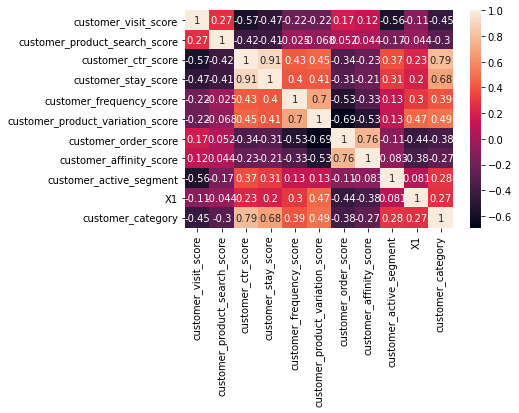

In [ ]:
g = sns.heatmap(train_df[["customer_visit_score","customer_product_search_score" ,"customer_ctr_score","customer_stay_score","customer_frequency_score","customer_product_variation_score","customer_order_score","customer_affinity_score","customer_active_segment","X1","customer_category"]].corr(),
annot=True)

,cust_ctr_score_band,customer_category
0,"(-0.549, 0.26]",0.016143
1,"(0.26, 1.067]",0.673696
2,"(1.067, 1.873]",0.993213
3,"(1.873, 2.679]",1.000000


,cust_visit_band,customer_category
0,"(0.522, 8.359]",0.905344
1,"(8.359, 16.148]",0.138062
2,"(16.148, 23.938]",0.052211
3,"(23.938, 31.727]",0.013256
4,"(31.727, 39.517]",0.002123
5,"(39.517, 47.307]",0.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


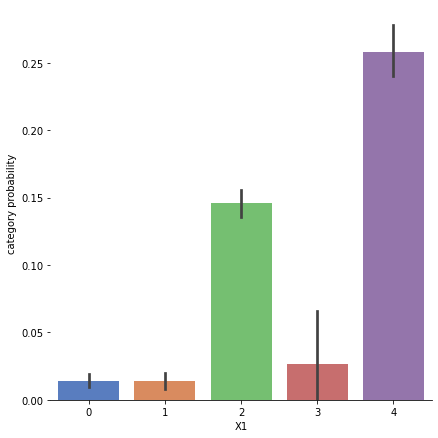

In [ ]:
g = sns.factorplot(x="X1",y="customer_category",data=train_df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("category probability")

In [ ]:
print(train_df[['customer_active_segment','customer_category']].groupby('customer_active_segment').count().sort_values(by='customer_active_segment'))

                         customer_category
customer_active_segment                   
0                                      412
1                                      414
2                                     4430
3                                     4942
4                                      536


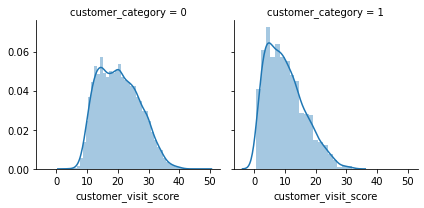

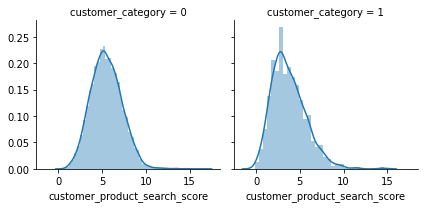

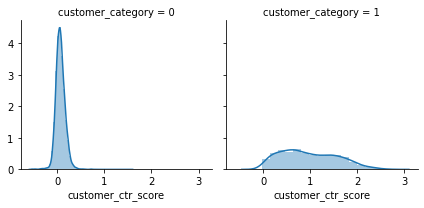

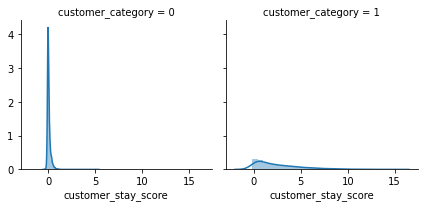

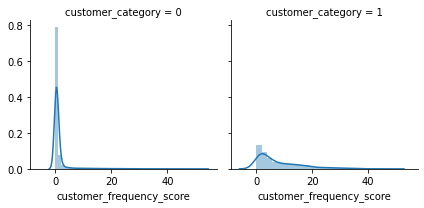

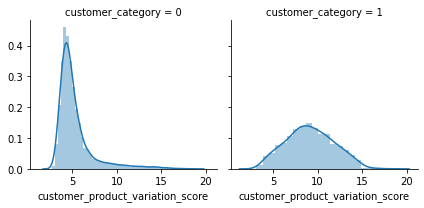

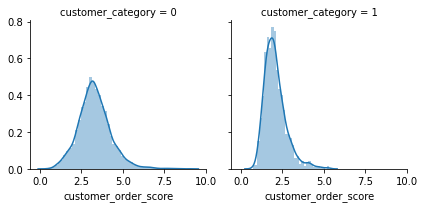

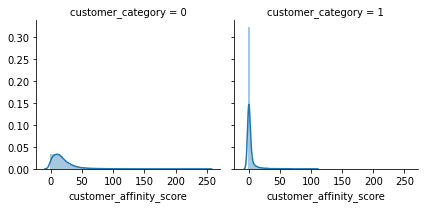

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_visit_score'))
#Customer visit score more towards zero is classified into category 1
g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_product_search_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_ctr_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_stay_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_frequency_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_product_variation_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_order_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_affinity_score'))


**checking skewness**

Legend


'\nWe can seee that some features have very high skewness hence need to do log transformation\n#otherwise This can lead to overweigth very high values in the model, even if it is scaled.\n'

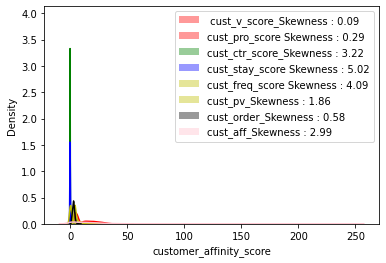

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.distplot(train_df['customer_visit_score'], color="r", label=" cust_v_score_Skewness : %.2f"%(train_df["customer_visit_score"].skew()))
#g = g.legend(loc="best")
###
g = sns.distplot(train_df['customer_product_search_score'], color="r", label="cust_pro_score Skewness : %.2f"%(train_df["customer_product_search_score"].skew()))
#g = g.legend(loc="best")
#
g = sns.distplot(train_df['customer_ctr_score'], color="g", label="cust_ctr_score_Skewness : %.2f"%(train_df["customer_ctr_score"].skew()))
#g = g.legend(loc="best")
#
g = sns.distplot(train_df['customer_stay_score'], color="b", label="cust_stay_score Skewness : %.2f"%(train_df["customer_stay_score"].skew()))
#g = g.legend(loc="best")

#
g = sns.distplot(train_df['customer_frequency_score'], color="y", label="cust_freq_score Skewness : %.2f"%(train_df["customer_frequency_score"].skew()))
#g = g.legend(loc="best")
#
g = sns.distplot(train_df['customer_product_variation_score'], color="y", label="cust_pv_Skewness : %.2f"%(train_df["customer_product_variation_score"].skew()))
#g = g.legend(loc="best")
#
g = sns.distplot(train_df['customer_order_score'], color="black", label="cust_order_Skewness : %.2f"%(train_df["customer_order_score"].skew()))
#g = g.legend(loc="best")
#
g = sns.distplot(train_df['customer_affinity_score'], color="pink", label="cust_aff_Skewness : %.2f"%(train_df["customer_affinity_score"].skew()))
print( g.legend(loc="best"))


'''
We can seee that some features have very high skewness hence need to do log transformation
#otherwise This can lead to overweigth very high values in the model, even if it is scaled.
'''

After Transformation Skewness
Legend


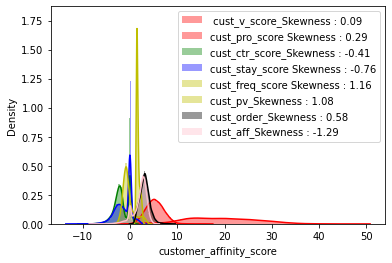

In [ ]:
train_df['customer_ctr_score']=train_df['customer_ctr_score'].map(lambda i:np.log(i) if i>0 else 0)
train_df['customer_stay_score']=train_df['customer_stay_score'].map(lambda i:np.log(i) if i>0 else 0)
train_df['customer_frequency_score']=train_df['customer_frequency_score'].map(lambda i:np.log(i) if i>0 else 0)
train_df['customer_affinity_score']=train_df['customer_affinity_score'].map(lambda i:np.log(i) if i>0 else 0)
train_df['customer_product_variation_score']=train_df['customer_product_variation_score'].map(lambda i:np.log(i) if i>0 else 0)

'''
test
'''
test_df['customer_ctr_score']=test_df['customer_ctr_score'].map(lambda i:np.log(i) if i>0 else 0)
test_df['customer_stay_score']=test_df['customer_stay_score'].map(lambda i:np.log(i) if i>0 else 0)
test_df['customer_frequency_score']=test_df['customer_frequency_score'].map(lambda i:np.log(i) if i>0 else 0)
test_df['customer_affinity_score']=test_df['customer_affinity_score'].map(lambda i:np.log(i) if i>0 else 0)
test_df['customer_product_variation_score']=test_df['customer_product_variation_score'].map(lambda i:np.log(i) if i>0 else 0)

print('After Transformation Skewness')
g = sns.distplot(train_df['customer_visit_score'], color="r", label=" cust_v_score_Skewness : %.2f"%(train_df["customer_visit_score"].skew()))
g = sns.distplot(train_df['customer_product_search_score'], color="r", label="cust_pro_score Skewness : %.2f"%(train_df["customer_product_search_score"].skew()))
g = sns.distplot(train_df['customer_ctr_score'], color="g", label="cust_ctr_score_Skewness : %.2f"%(train_df["customer_ctr_score"].skew()))
g = sns.distplot(train_df['customer_stay_score'], color="b", label="cust_stay_score Skewness : %.2f"%(train_df["customer_stay_score"].skew()))
g = sns.distplot(train_df['customer_frequency_score'], color="y", label="cust_freq_score Skewness : %.2f"%(train_df["customer_frequency_score"].skew()))
g = sns.distplot(train_df['customer_product_variation_score'], color="y", label="cust_pv_Skewness : %.2f"%(train_df["customer_product_variation_score"].skew()))
g = sns.distplot(train_df['customer_order_score'], color="black", label="cust_order_Skewness : %.2f"%(train_df["customer_order_score"].skew()))
g = sns.distplot(train_df['customer_affinity_score'], color="pink", label="cust_aff_Skewness : %.2f"%(train_df["customer_affinity_score"].skew()))
print( g.legend(loc="best"))


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_visit_score'))
#Customer visit score more towards zero is classified into category 1
g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_product_search_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_ctr_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_stay_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_frequency_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_product_variation_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_order_score'))

g = sns.FacetGrid(train_df,col='customer_category')
print(g.map(sns.distplot,'customer_affinity_score'))


***accuracy:90.88**

In [ ]:
X_train=train_df.drop('customer_category',axis=1)
Y_train=train_df['customer_category']
X_test  = test_df.drop("customer_id", axis=1).copy()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

svm = SVC(C = 100)
svm.fit(X_train,Y_train)
Y_pred_svm=svm.predict(X_test)
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)
print(acc_svm)

pred = pd.DataFrame(Y_pred_svm)
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predsvm_skew.csv',index = False)



(10734, 10)
(10734,)
(7160, 10)
96.04


In [ ]:
from sklearn.neural_network import MLPClassifier
print(len(X_train))
parameter_space = {
    'hidden_layer_sizes': [(50,50,50),(100,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp = MLPClassifier(max_iter=300)
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train[:9000], Y_train[:9000])
print('Best parameters found:\n', clf.best_params_)
# acc_clf = round(clf.score(X_train[9000:], Y_train[9000:]) * 100, 2)
# print(acc_clf)
y_true, y_pred = Y_train[9000:] , clf.predict(X_train[9000:])
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

                       
pred = pd.DataFrame(clf.predict(X_test))
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predclf_skew.csv',index = False)


10734
Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1604
           1       0.84      0.86      0.85       130

    accuracy                           0.98      1734
   macro avg       0.92      0.92      0.92      1734
weighted avg       0.98      0.98      0.98      1734



**accuracy:33**

In [ ]:
#checking score after log transformation
#train_df=train_df.drop(['customer_id'],axis=1)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_df = pd.DataFrame(ss.fit_transform(train_df),columns = train_df.columns)


X_train=train_df.drop('customer_category',axis=1)
Y_train=train_df['customer_category']
X_test  = test_df.drop("customer_id", axis=1).copy()
X_test = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

Y_train = pd.DataFrame(Y_train.astype('int'))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

svm = SVC(C = 20)
svm.fit(X_train,Y_train)
Y_pred_svm=svm.predict(X_test)
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)
print(acc_svm)

pred = pd.DataFrame(Y_pred_svm)
pred.head()
#pred.rename(columns={'0':"customer_category"},inplace=True)
cid = test_df["customer_id"]
cc = pred[:]
cid.head()
pred['customer_category'] = cc
pred['customer_id'] = cid
columns_titles = ["customer_id","customer_category"]
pred=pred.reindex(columns=columns_titles)
pred.head()
pred.to_csv(r'/content/Predsvm_scaled.csv',index = False)
